In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import seaborn as sns
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorSamples, PosteriorCoverage, PlotSinglePosterior
import h5py
from sklearn.decomposition import PCA
from funcs import *
np.random.seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

ModuleNotFoundError: No module named 'ili'

In [19]:
import glob, os
len(glob.glob("/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/*/diag/galaxies/*_wst.h5"))

10000

In [53]:
# path = '/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/*/galaxies/'
# files = glob.glob(path+'/*')
os.path.basename(files[0]).split('.')[0]


'hod07054'

In [25]:
h5py.File("/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/705/diag/galaxies/hod07050.h5")['0.666667']['Pk'][()]

array([[ 5.58022504e+04,  6.56432160e+04,  8.72034772e+04],
       [ 9.47330248e+04,  4.59838162e+02,  5.28597524e+02],
       [ 6.48483298e+04,  5.99096426e+03, -3.35990168e+04],
       [ 6.01528481e+04,  2.65603649e+03, -2.72612545e+04],
       [ 7.00398366e+04,  4.11380130e+03,  5.44572949e+03],
       [ 6.05803992e+04,  2.21280678e+03, -5.10231157e+03],
       [ 5.17695126e+04, -2.52209304e+03,  5.25218899e+03],
       [ 5.00716536e+04,  3.26248793e+03,  8.76818226e+03],
       [ 4.59362607e+04, -4.24867635e+03,  4.92270120e+03],
       [ 4.15992537e+04,  9.92160924e+02, -1.19517740e+03],
       [ 4.11567252e+04, -1.63184897e+03,  1.00482132e+03],
       [ 3.72340312e+04, -8.09811906e+02, -1.72047883e+03],
       [ 3.21879783e+04, -8.42178549e+02,  2.66248337e+03],
       [ 3.04944869e+04, -3.07516803e+03,  1.73724214e+03],
       [ 2.77813937e+04, -5.75098309e+02,  1.38980281e+03],
       [ 2.78806082e+04,  2.19954143e+03,  4.56925039e+02],
       [ 2.49422188e+04,  1.88042166e+03

In [ ]:
ids_train=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zwst/ids_train.npy").astype(int)
ids_val=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zwst/ids_val.npy").astype(int)
ids_test=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zwst/ids_test.npy").astype(int)

In [ ]:
quijotelike=pd.read_csv("Dataset/quijotelike/fastpm/L1000-N128/zhalos.csv").set_index('id')

train_set=quijotelike.loc[ids_train]
val_set=quijotelike.loc[ids_val]
test_set=quijotelike.loc[ids_test]

fid_set=pd.read_csv("Dataset/quijotelike-fid/fastpm/L1000-N128/zhalos.csv")

quijote=pd.read_csv("Dataset/quijote/nbody/L1000-N128/zhalos.csv").set_index('id')
quijote_set=quijote.loc[ids_test]

params_set=["Omega_m", "Omega_b", "h", "n_s", "sigma_8"]
params=params_set[:]
# params=["Omega_m", "sigma_8"]

In [15]:
pb=np.load('/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/x_val.npy')
wst=np.load('/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/models/halo/zwst/x_val.npy')
summ=np.concatenate([pb,wst],axis=1)
np.save('/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/x_val.npy',summ)

In [6]:
train_x, train_theta=process_data(data=train_set, params=params)
val_x, val_theta=process_data(data=val_set, params=params)
test_x, test_theta=process_data(data=test_set, params=params)
fid_x, fid_theta=process_data(data=fid_set, params=params)
quijote_x, quijote_theta=process_data(data=quijote_set, params=params)

In [2]:
file='/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0+zwst/kmax-0.4/'
train_x, train_theta = np.load(file+'x_train.npy'), np.load(file+'theta_train.npy')
val_x, val_theta = np.load(file+'x_val.npy'), np.load(file+'theta_val.npy')
test_x, test_theta = np.load(file+'x_test.npy'), np.load(file+'theta_test.npy')

In [39]:
pca = PCA(n_components=100)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)
fid_x = pca.transform(fid_x)
quijote_x = pca.transform(quijote_x)
explained_variance = pca.explained_variance_ratio_

In [40]:
# mean=fid_x.mean(axis=0)
# std=fid_x.std(axis=0)
# train_x=(train_x-mean)/std
# test_x=(test_x-mean)/std
# fid_x = (fid_x-mean)/std

In [3]:
# make a dataloader
loader = NumpyLoader(x=train_x, theta=train_theta)

In [4]:
loader.simulator

AttributeError: 'NumpyLoader' object has no attribute 'simulator'

In [73]:
# id=0,144,663
# s0_quijote=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/663/diag/WST/S0_J6_L6_q0.5/halos.npy").astype(np.float64).flatten()
s0_quijote=h5py.File("/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/663/diag/halos_wst.h5")['zS0'][()].astype(np.float64).flatten()
# s12_quijote=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/663/diag/WST/S12_J6_L6_q0.5/halos.npy").astype(np.float64).flatten()
s12_quijote=h5py.File("/anvil/scratch/x-abairagi/cmass-ili/quijote/nbody/L1000-N128/663/diag/halos_wst.h5")['zS12'][()].astype(np.float64).flatten()
test_x_quijote=np.concatenate([s0_quijote,s12_quijote])
test_x_quijote=np.log(test_x_quijote)
test_theta_quijote=[0.3223 , 0.04625, 0.7015 , 0.9607 , 0.8311 ]
# test_theta_quijote=[0.3667, 0.8503]
# test_theta_quijote=[0.3223 , 0.8311 ]

In [74]:
# s0_quijotelike=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/L1000-N128/663/diag/WST/S0_J6_L6_q0.5/halos.npy").astype(np.float64).flatten()
s0_quijotelike=h5py.File("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/L1000-N128/663/diag/halos_wst.h5")['zS0'][()].astype(np.float64).flatten()
# s12_quijotelike=np.load("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/L1000-N128/663/diag/WST/S12_J6_L6_q0.5/halos.npy").astype(np.float64).flatten()
s12_quijotelike=h5py.File("/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/L1000-N128/663/diag/halos_wst.h5")['zS12'][()].astype(np.float64).flatten()
test_x_quijotelike=np.concatenate([s0_quijotelike,s12_quijotelike])
test_x_quijotelike=np.log(test_x_quijotelike)

In [9]:
test_x_quijote= pca.transform([test_x_quijote])
test_x_quijotelike= pca.transform([test_x_quijotelike])

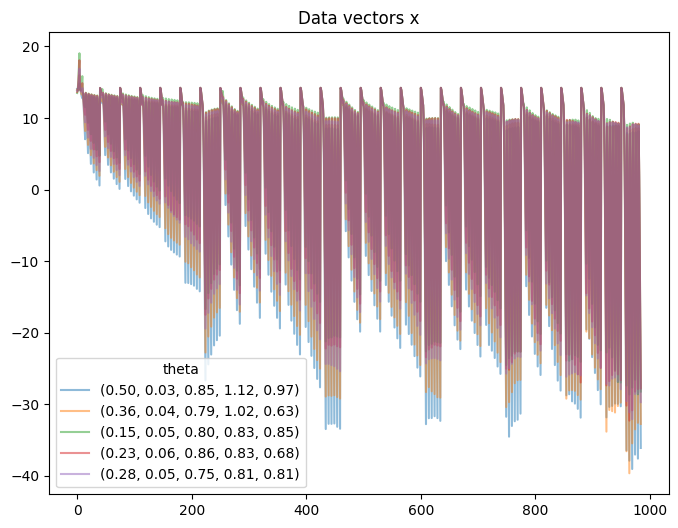

In [27]:
# plot some examples of the data
x=train_x
theta=train_theta
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

In [25]:
# test_x_quijotelike/test_x_quijote

(0.0, 2.0)

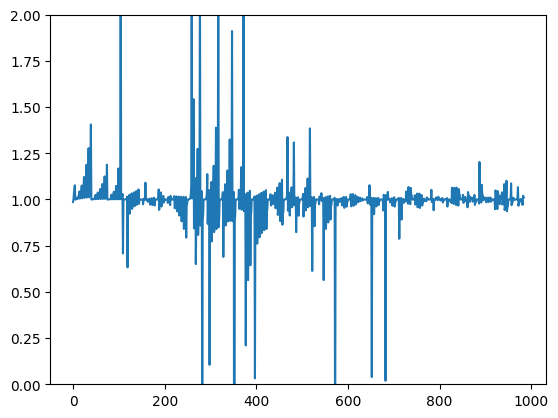

In [88]:
plt.plot(test_x_quijotelike/test_x_quijote)
plt.ylim(0,2)
# plt.plot(test_x_quijote)

In [50]:
# theta=train_theta_pmwd
# define a prior
# prior = ili.utils.Uniform(low=[theta[:,0].min(), theta[:,1].min(), theta[:,2].min(), theta[:,3].min(), theta[:,4].min()], high=[theta[:,0].max(), theta[:,1].max(), theta[:,2].max(), theta[:,3].max(), theta[:,4].max()], device=device)
prior = ili.utils.Uniform(low=[0.1, 0.02, 0.5, 0.8, 0.6], high=[0.5, 0.08, 0.9, 1.2, 1], device=device)
# prior = ili.utils.Uniform(low=[theta[:,0].min(), theta[:,1].min()], high=[theta[:,0].max(), theta[:,1].max()], device=device)
# prior = ili.utils.Uniform(low=[0.1, 0.6], high=[0.5, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5),
    # ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 16,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [51]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 25

INFO:root:It took 30.718402862548828 seconds to train models.


 Neural network successfully converged after 26 epochs.

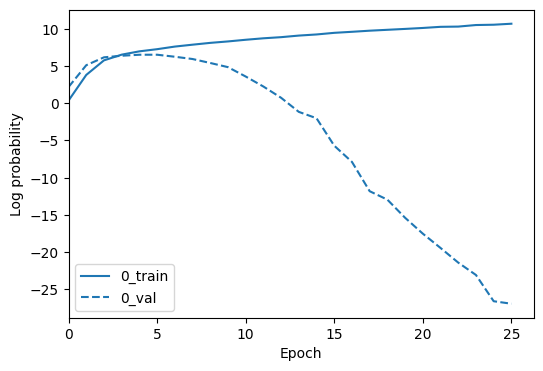

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [53]:
test_theta[68]

array([0.3877 , 0.06547, 0.6621 , 0.9455 , 0.8355 ])

Drawing 1000 posterior samples: 1334it [00:00, 2519.12it/s]                         


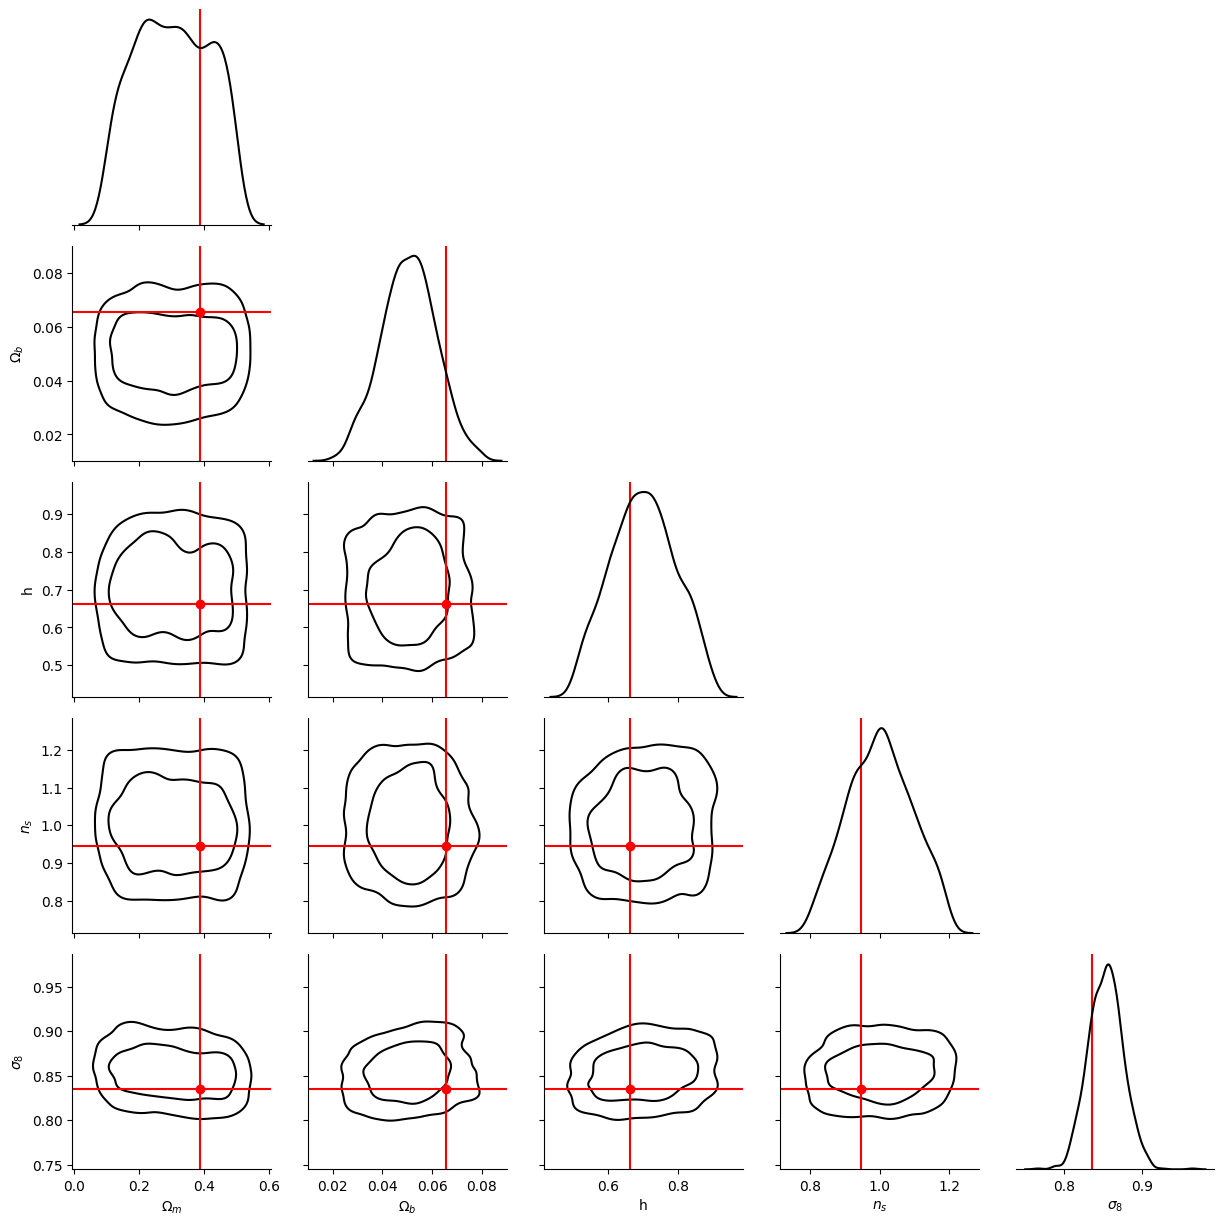

In [55]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)
ind=68
fig = metric(
    posterior=posterior_ensemble,
    x_obs = test_x[ind], theta_fid=test_theta[ind]
)

Drawing 1000 posterior samples: 1049it [00:00, 7280.03it/s]             


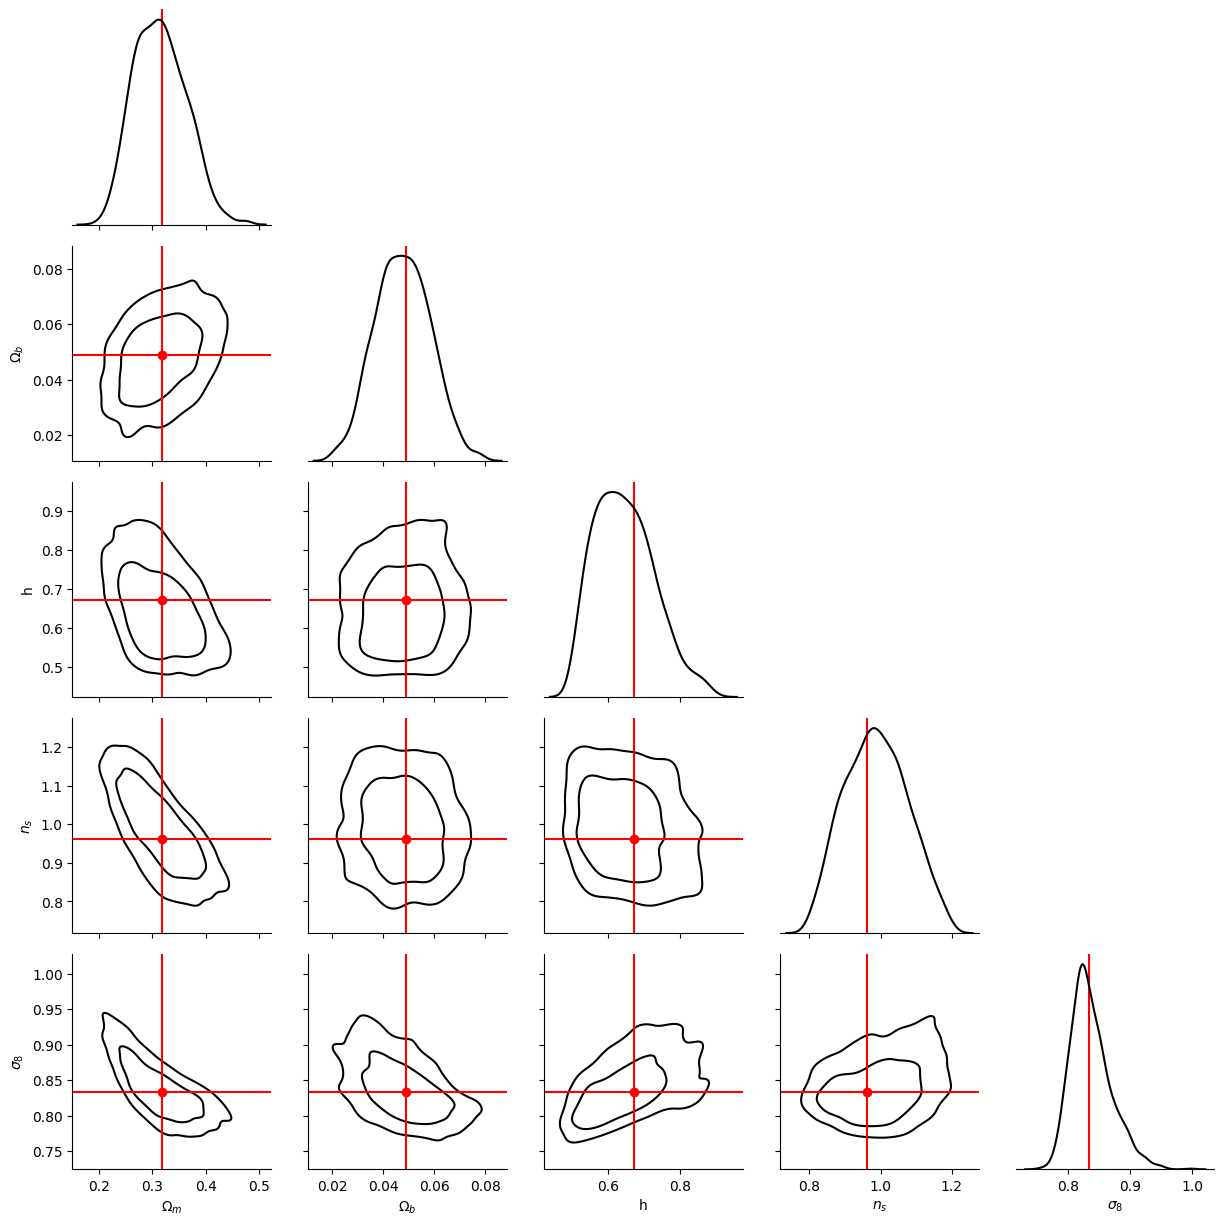

In [84]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)
ind=14
fig = metric(
    posterior=posterior_ensemble,
    x_obs = fid_x[ind], theta_fid=fid_theta[ind]
)

Drawing 1000 posterior samples: 1054it [00:00, 11867.50it/s]            


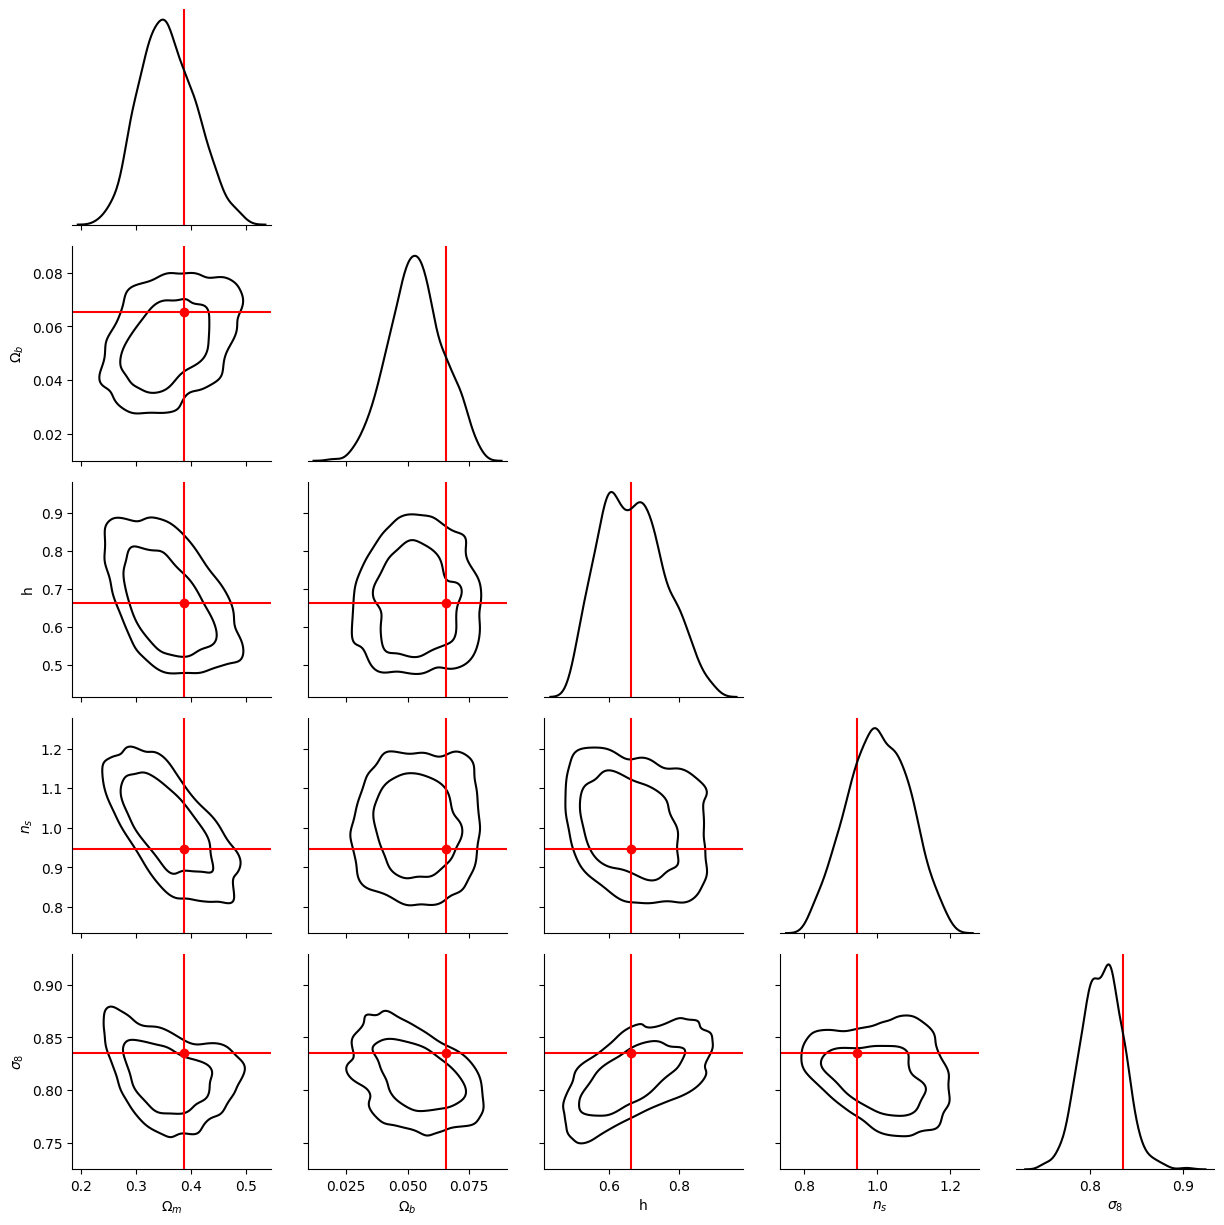

In [128]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)

fig = metric(
    posterior=posterior_ensemble,
    x_obs = quijote_x[68], theta_fid=quijote_theta[68]
    # x_obs = test_x_quijote, theta_fid=test_theta_quijote
)

Drawing 1000 posterior samples: 1041it [00:00, 12237.00it/s]            
Drawing 1000 posterior samples: 1049it [00:00, 12401.80it/s]            


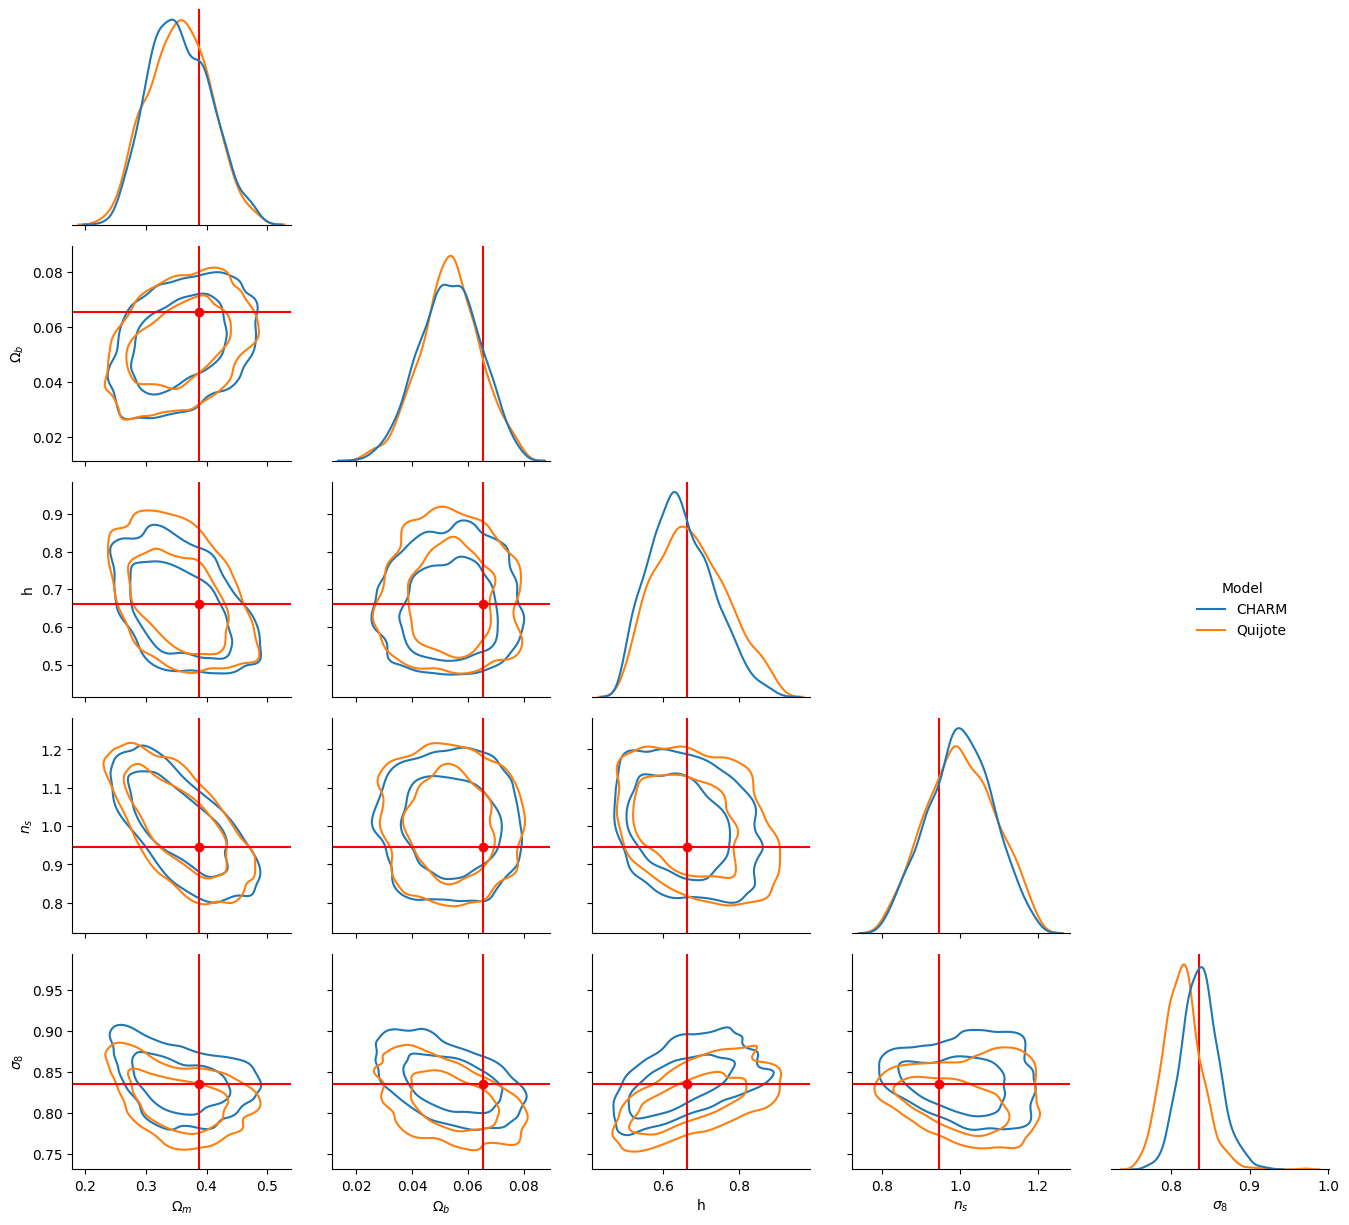

In [127]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    # labels=["$\Omega_m$", "$\sigma_8$"]
    labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"]
)

ind=68
fig = metric(
    posterior=posterior_ensemble,
    # x_obs = test_x_quijotelike, theta_fid=test_theta_quijote,
    x_obs = test_x[ind], theta_fid=test_theta[ind],
    name = 'CHARM'
)

fig = metric(
    posterior=posterior_ensemble,
    # x_obs = test_x_quijote, theta_fid=test_theta_quijote,
    x_obs = quijote_x[ind], theta_fid=quijote_theta[ind],
    name = 'Quijote',
    grid = fig
)

100%|██████████| 200/200 [01:52<00:00,  1.78it/s]
INFO:root:Mean logprob: 7.2687e+00Median logprob: 7.6357e+00
100%|██████████| 100/100 [00:02<00:00, 41.22it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


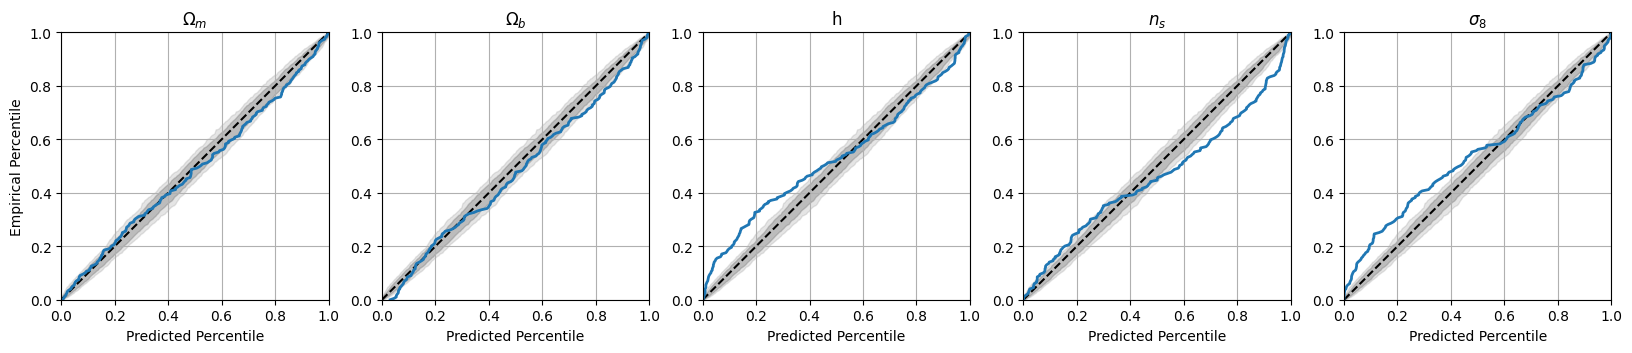

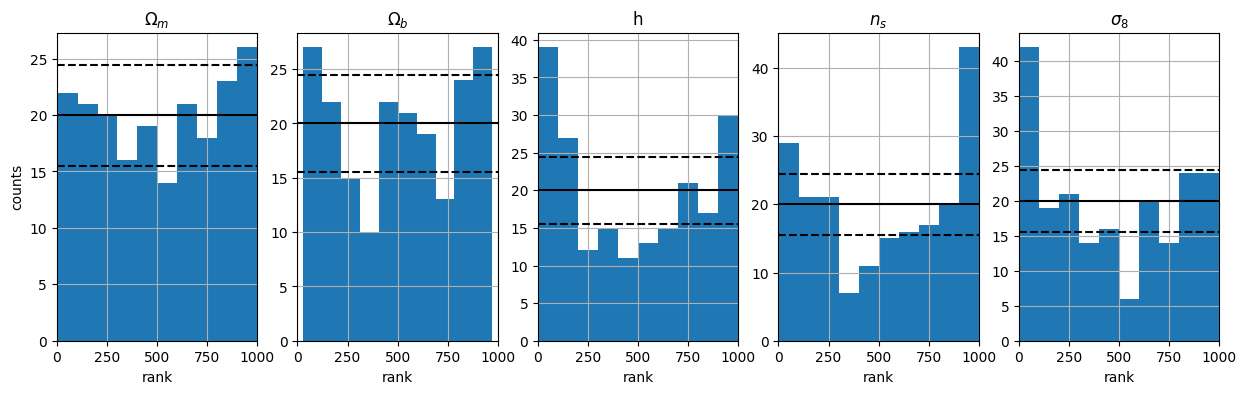

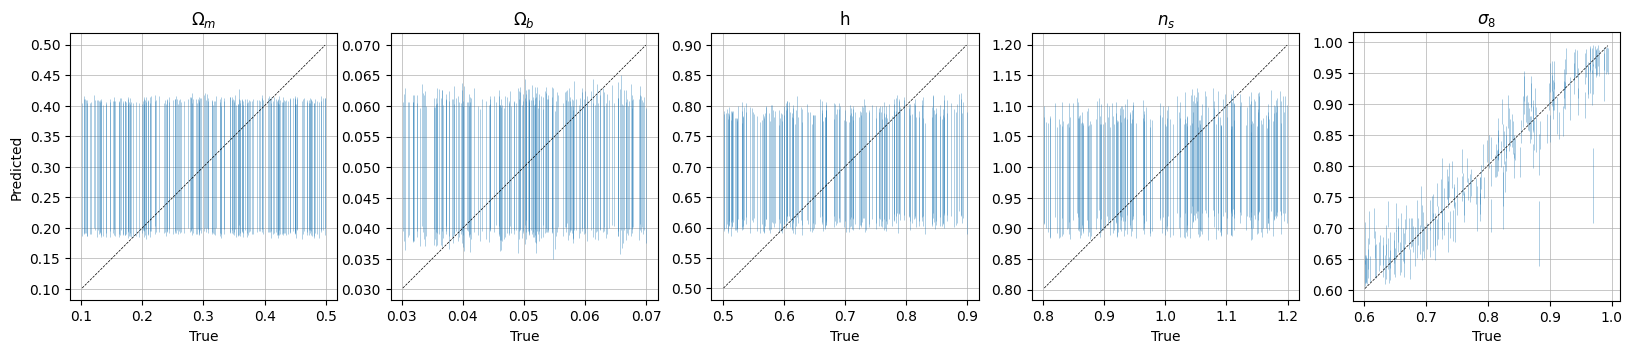

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


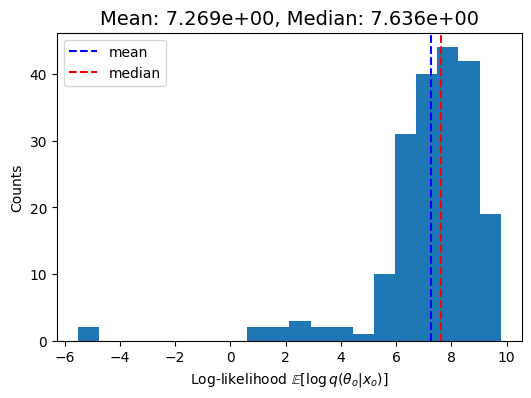

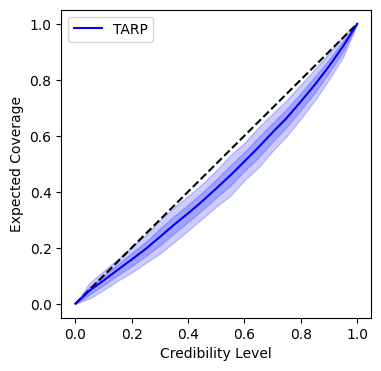

In [56]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=posterior_ensemble,
#     .posteriors[0],
    x=test_x, theta=test_theta
)

100%|██████████| 200/200 [00:29<00:00,  6.86it/s]
INFO:root:Mean logprob: 7.7375e+00Median logprob: 9.3979e+00
100%|██████████| 100/100 [00:01<00:00, 67.35it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


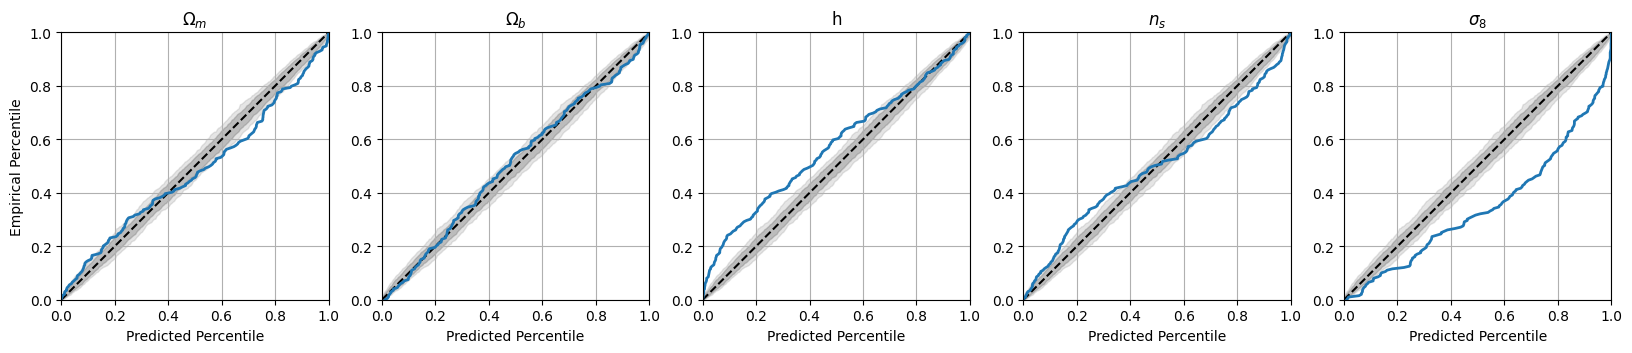

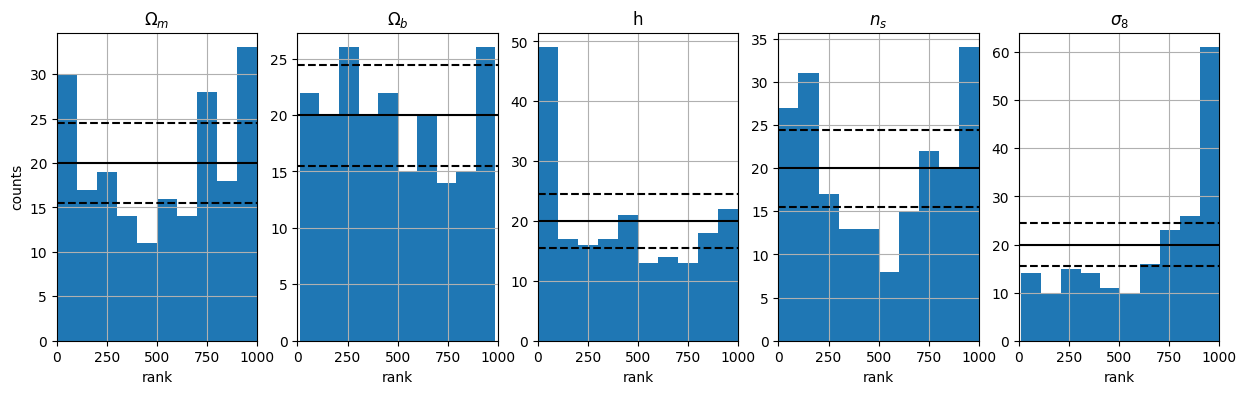

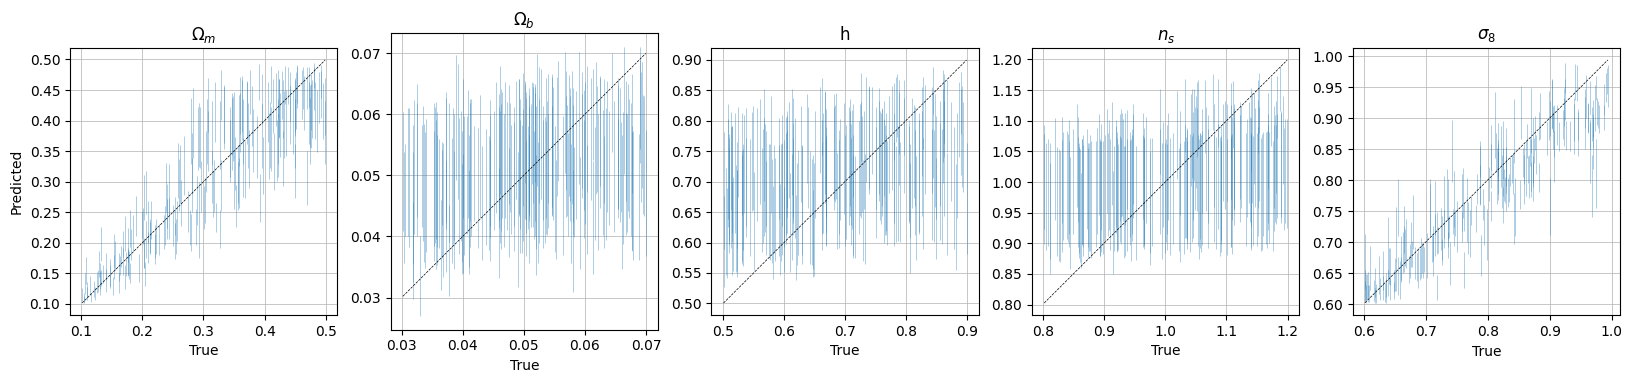

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


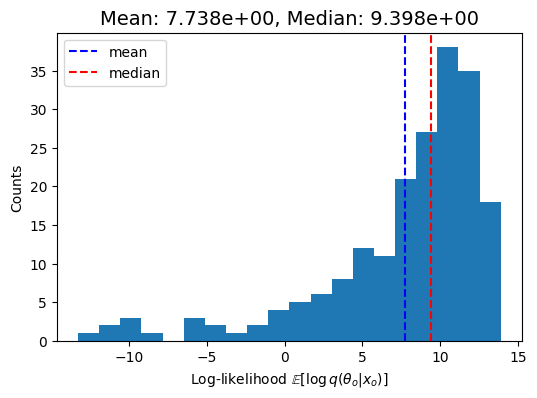

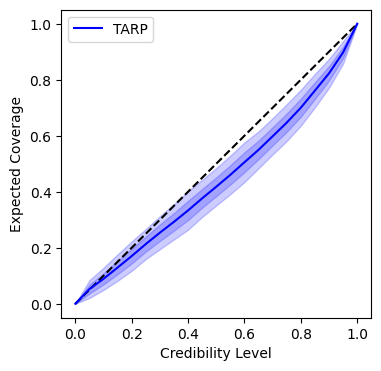

In [138]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"])

fig = metric(
    posterior=posterior_ensemble,
#     .posteriors[0],
    x=quijote_x, theta=quijote_theta
)

In [57]:
ps_matt=np.load("/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/posterior_samples.npy")
matt_id=np.load("/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/ids_test.npy")
matt_test_x=np.load("/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/x_test.npy")
matt_test_theta=np.load("/anvil/scratch/x-mho1/cmass-ili/quijotelike/fastpm/models/halo/zPk0+zPk2+zPk4+zQk0/kmax-0.4/theta_test.npy")

In [136]:
test_set['Filename'].iloc[68]

'/anvil/scratch/x-abairagi/cmass-ili/quijotelike/fastpm/L1000-N128/677/diag/halos_wst.h5'

In [63]:
# choose a random input
ind = 68

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(test_x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(test_x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

Drawing 1000 posterior samples: 1226it [00:00, 2644.44it/s]                         


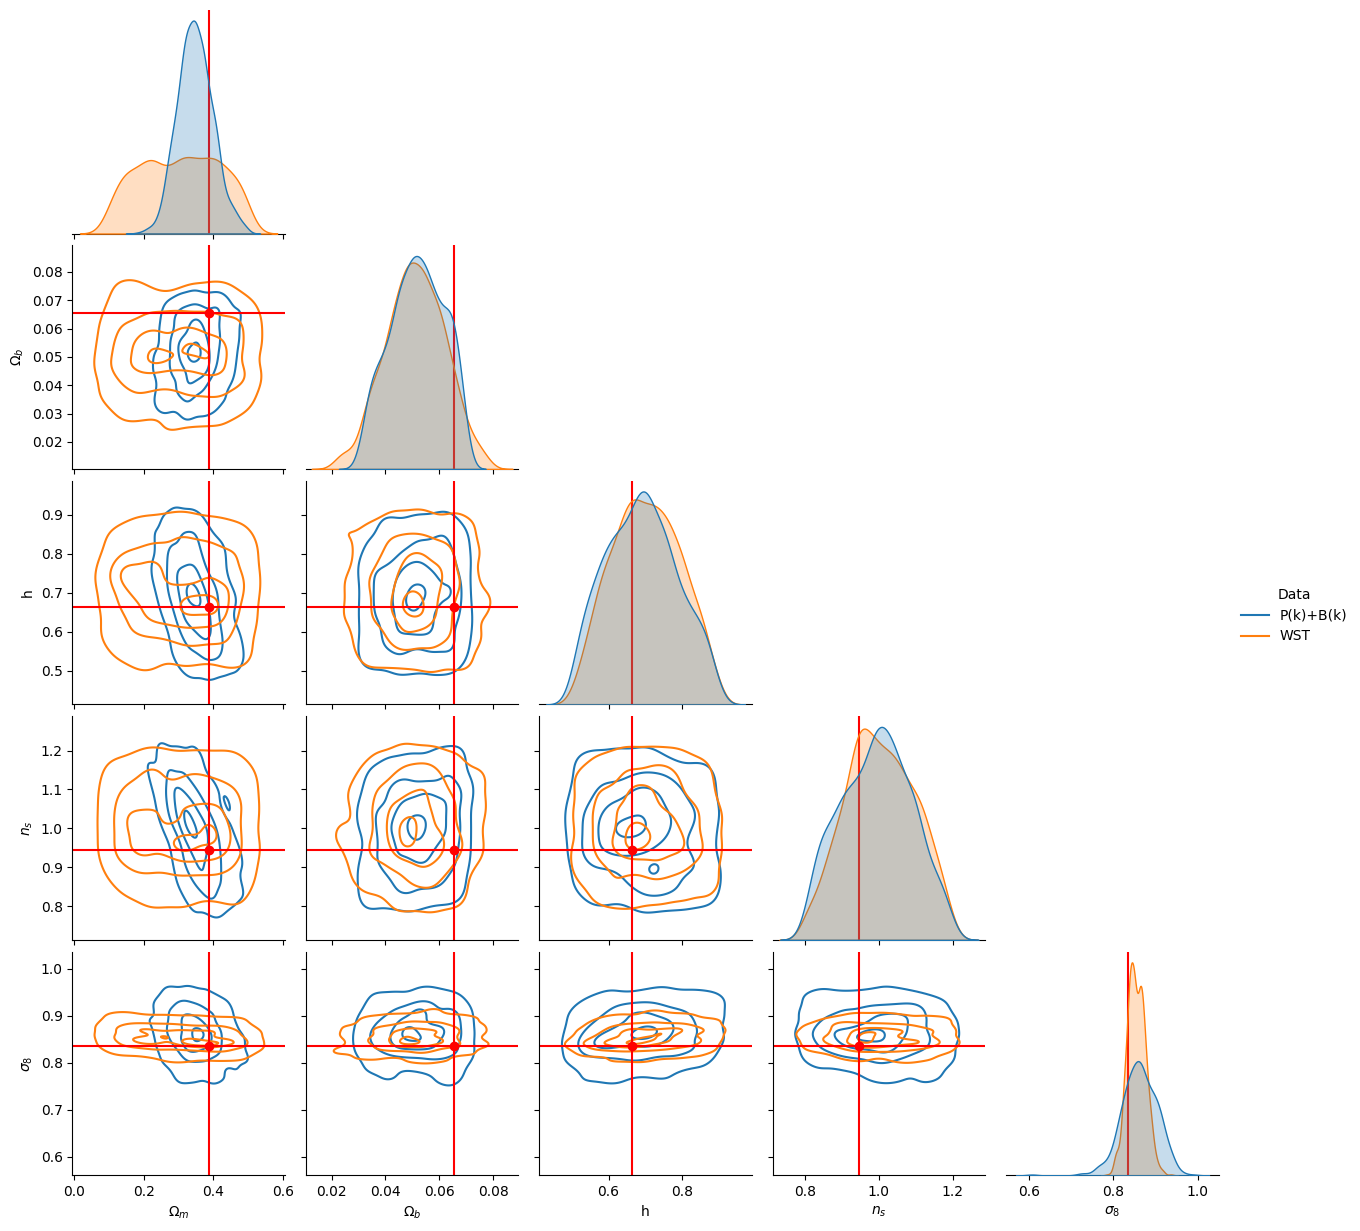

In [64]:
ind=68
df_matt=pd.DataFrame(ps_matt[:,ind], columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df_ab=pd.DataFrame(samples, columns=["$\Omega_m$", "$\Omega_b$", "h", "$n_s$", "$\sigma_8$"])
df_matt["Data"]="P(k)+B(k)"
df_ab["Data"]="WST"
df = pd.concat([df_matt, df_ab])
theta = matt_test_theta[ind]
fig=sns.pairplot(df, kind="kde", corner=True, hue="Data", plot_kws=dict(common_norm=False, levels=[0.05, 0.32, 0.68, 0.95]))
    
for i in range(5):
    for j in range(i + 1):
        if i == j:
            fig.axes[i, i].axvline(theta[i], color="r")
        else:
            fig.axes[i, j].axhline(theta[i], color="r")
            fig.axes[i, j].axvline(theta[j], color="r")
            fig.axes[i, j].plot(theta[j], theta[i], "ro")
            

In [57]:
samples

array([[0.4298866 , 0.05059568, 0.775807  , 0.93170536, 0.79379565],
       [0.3711693 , 0.04894958, 0.74145234, 1.0479339 , 0.7568283 ],
       [0.41575307, 0.06274018, 0.7883466 , 0.97274345, 0.77653754],
       ...,
       [0.33765593, 0.03491286, 0.7852314 , 1.0405215 , 0.78116214],
       [0.34673625, 0.04734814, 0.78611314, 1.0473156 , 0.7764883 ],
       [0.39344332, 0.03658608, 0.61594546, 1.0783783 , 0.7636069 ]],
      dtype=float32)

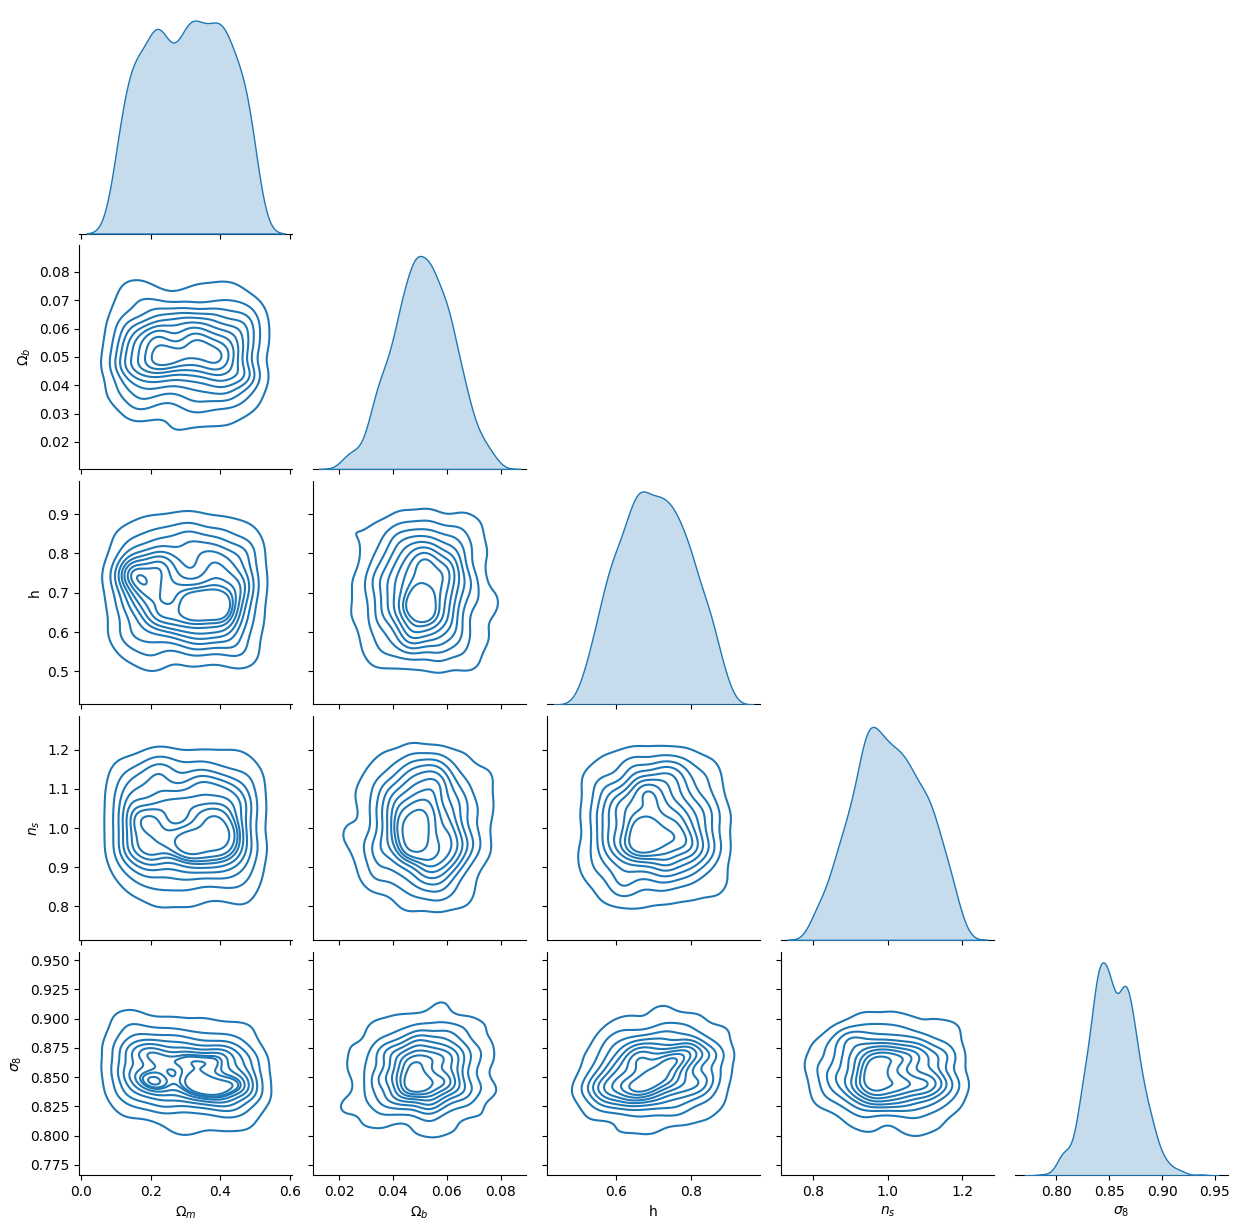

In [60]:
sns.pairplot(df_ab, kind="kde", corner=True)